# Import Packages

In [18]:
import os
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Voting

### The Law of Large Number

In [19]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cum_head_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

[0, 10000, 0.42, 0.58]

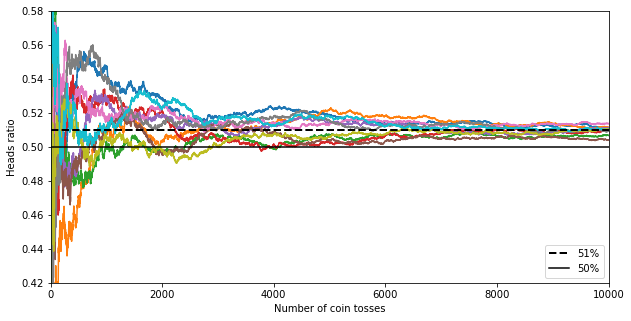

In [20]:
plt.figure(figsize=(10,5))
plt.plot(cum_head_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

### Hard Voting

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

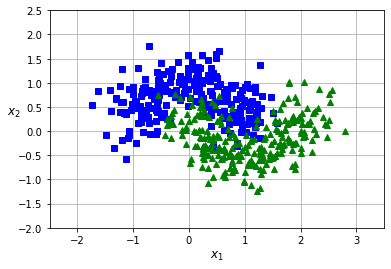

In [42]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=12)
    plt.ylabel(r"$x_2$", fontsize=12, rotation=0)

plot_dataset(X, y, [-2.5, 3.5, -2, 2.5])
plt.show()

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting = 'hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [46]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### Soft Voting
If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class **with the
highest class probability, averaged over all the individual classifiers.** This is called **soft
voting.** It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and **ensure that all classifiers can estimate class probabilities.** This is
not the case of the SVC class by default, so you need to set its probability hyperparameter
to True (this will make the SVC class use cross-validation to estimate class probabilities,
slowing down training, and it will add a predict_proba() method). If you modify the preceding code to use soft voting, you will find that the voting classifier
achieves over 91.2% accuracy!

In [47]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)  # for predict_proba

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [48]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting

Another approach is to use the same training algorithm for every
predictor, but to train them **on different random subsets of the training set.** When
sampling is performed **with replacement**, this method is called **bagging** (short for
bootstrap aggregating). When sampling is performed without replacement, it is called
pasting.
<br><br>
In other words, both bagging and pasting allow training instances to be sampled several
times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor.
<br><br>
Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression.
<br><br>
Each predictor has a higher bias than if it were trained on the original training set, but
**aggregation reduces both bias and variance**. Generally, the net result is that the
ensemble has a similar bias but a lower variance than a single predictor trained on the
original training set.

In [51]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100,
    bootstrap=True, n_jobs=-1
)                                              # bootstrap=False : Pasting
                                                        
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


The BaggingClassifier **automatically performs soft voting**
instead of hard voting if the base classifier can estimate class probabilities
(i.e., if it has a predict_proba() method), which is the case
with Decision Trees classifiers.

In [53]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [54]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

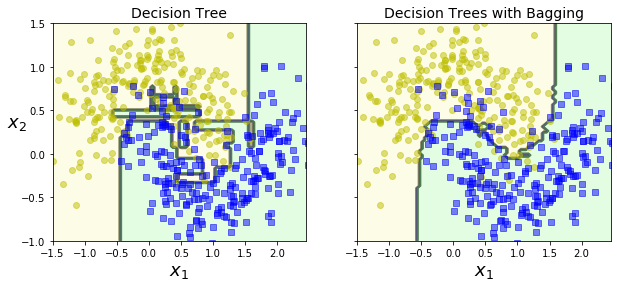

In [55]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

As you can see, **the ensemble’s predictions will likely
generalize** much better than the single Decision Tree’s predictions: the ensemble has a
comparable bias but a smaller variance (it makes roughly the same number of errors
on the training set, but the decision boundary is less irregular).
<br><br>
Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a **slightly higher bias** than pasting, but this also
means that predictors end up being **less correlated so the ensemble’s variance is
reduced.** Overall, bagging often results in better models, which explains why it is generally
preferred. However, if you have spare time and CPU power you can use crossvalidation
to evaluate both bagging and pasting and select the one that works best.

### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor. The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
for all predictors.<br><br>
Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. You can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.

In [60]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [61]:
bag_clf.oob_score_

0.9013333333333333

In [62]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

### Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the **features** as well. This is controlled
by two hyperparameters: `max_features` and `bootstrap_features`. They work
the same way as `max_samples` and `bootstrap`, but **for feature sampling instead of
instance sampling.** Thus, each predictor will be trained on a random subset of the
input features.<br><br>
This is particularly useful when you are dealing with high-dimensional inputs (such
as images). <br><br>**Sampling both training instances and features is called the Random
Patches method.** <br><br>**Keeping all training instances (i.e., `bootstrap=False` and `max_samples=1.0`) but sampling features (i.e., `bootstrap_features=True` and/or `max_features smaller than 1.0`) is called the Random Subspaces method.**

# Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes =16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [64]:
accuracy_score(y_test, y_pred_rf)

0.92

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a
`DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters
of a `BaggingClassifier` to control the ensemble itself.

### Extremely Randomized Trees

When you are growing a tree in a Random Forest, at each node only a random subset
of the features is considered for splitting (as discussed earlier). It is possible to make
trees even more random by also using random thresholds for each feature rather than
searching for the best possible thresholds (like regular Decision Trees do).
<br><br>
A forest of such extremely random trees is simply called an **Extremely Randomized
Trees ensemble (or Extra-Trees for short).** Once again, this trades **more bias for a
lower variance.** It also makes Extra-Trees much faster to train than regular Random
Forests since finding the best possible threshold for each feature at every node is one
of the most time-consuming tasks of growing a tree.
<br><br>
You can create an Extra-Trees classifier using Scikit-Learn’s `ExtraTreesClassifier`
class. Its API is identical to the `RandomForestClassifier` class. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class.

### Feature Importances

Yet another great quality of Random Forests is that they make it easy to measure the
relative importance of each feature. Scikit-Learn measures a feature’s importance by
looking at **how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest).** More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it.

In [65]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [66]:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09821636289699946
sepal width (cm) 0.022308847274670897
petal length (cm) 0.42594258456768785
petal width (cm) 0.4535322052606418


Random Forests are very handy to get a quick understanding of what features
actually matter, in particular if you need to perform feature selection.

# Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can **combine several weak learners into a strong learner.** The general idea of most
boosting methods is to train predictors **sequentially**, each trying to correct its predecessor.
There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting. Let’s start with AdaBoost.

### AdaBoost
One way for a new predictor to correct its predecessor is **to pay a bit more attention
to the training instances that the predecessor underfitted.** This results in new predictors
focusing more and more on the hard cases. This is the technique used by Ada‐
Boost.<br><br>
For example, to build an AdaBoost classifier, a first base classifier (such as a Decision
Tree) is trained and used to make predictions on the training set. The relative weight
of misclassified training instances is then increased. A second classifier is trained
using the updated weights and again it makes predictions on the training set, weights
are updated, and so on

In [67]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

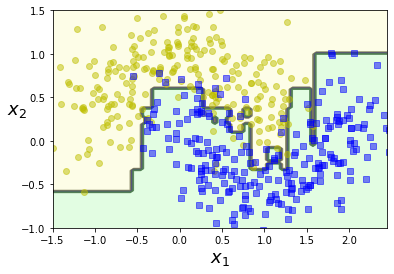

In [68]:
plot_decision_boundary(ada_clf, X, y)

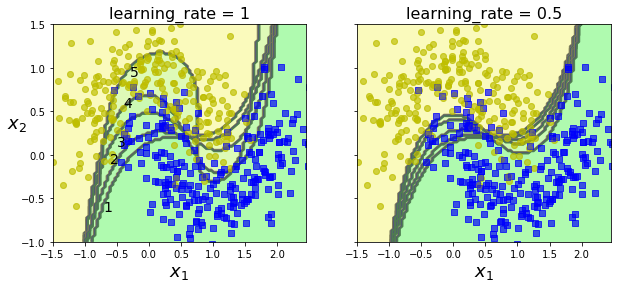

In [69]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

**SVMs are generally not good base predictors for AdaBoost, because they
are slow and tend to be unstable with AdaBoost.**

### Gradient Boosting

Another very popular Boosting algorithm is Gradient Boosting.17 Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, **this method tries to fit the new predictor to the residual
errors made by the previous predictor.**<br><br>
Let’s go through a simple regression example using Decision Trees as the base predictors
(of course Gradient Boosting also works great with regression tasks). This is
called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s
fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training
set):

In [70]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [73]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [75]:
y2 = y - tree_reg1.predict(X) # residual errors made by the first predictor
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [76]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [77]:
X_new = np.array([[0.8]])

In [79]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [83]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

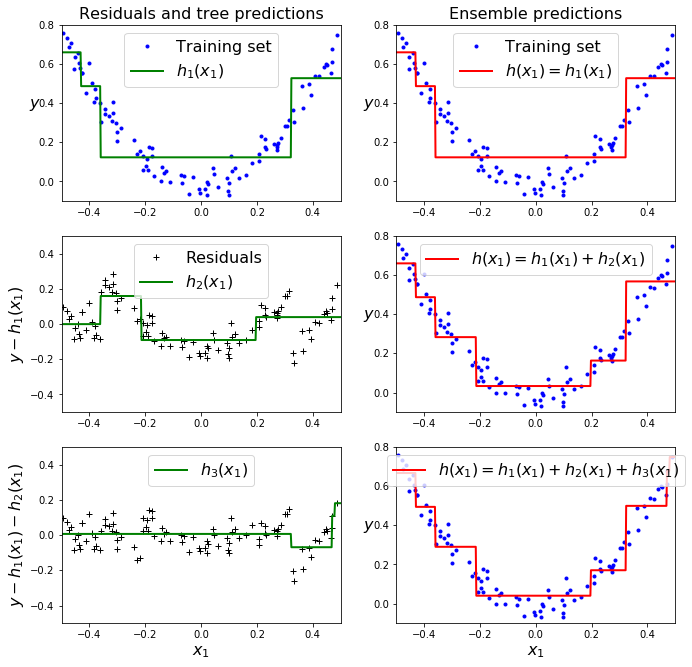

In [84]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

In [88]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [92]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

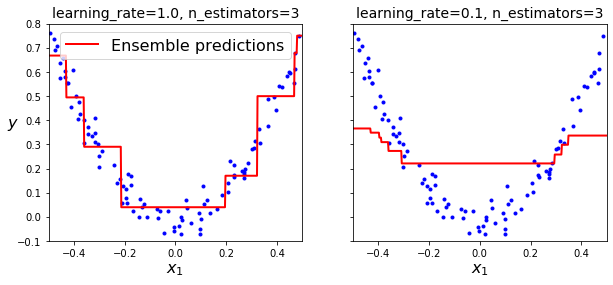

In [93]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("gbrt_learning_rate_plot")
plt.show()

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1, you will need more trees in the ensemble to fit the training
set, but the predictions will usually generalize better. This is a regularization technique
called shrinkage. Figure above shows two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.

### Early Stopping

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [97]:
min_error = np.min(errors)

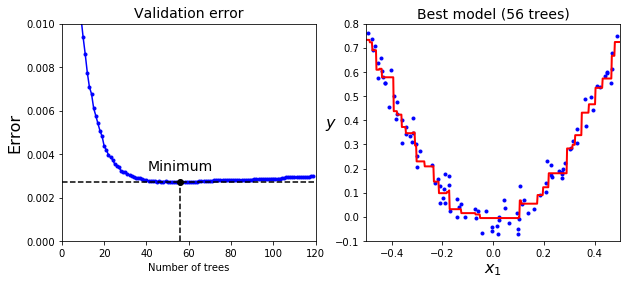

In [101]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("early_stopping_gbrt_plot")
plt.show()

In [106]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
        
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [107]:
print(gbrt.n_estimators)

61


In [108]:
print(min_val_error)

0.002712853325235463


The `GradientBoostingRegressor` class also supports a `subsample` hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if `subsample=0.25`, then each tree is trained on 25% of the training instances,
selected randomly. As you can probably guess by now, this trades a higher bias
for a lower variance. It also speeds up training considerably. This technique is called
Stochastic Gradient Boosting.

### XGBoost

In [110]:
!pip install xgboost

In [114]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [115]:
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error) 

Validation MSE: 0.00400040950714611


# Stacking

Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard
to roll out your own implementation.